In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Training with data augmentation

In [5]:
from torch import nn
from torch.nn import init
import torch.nn.functional as F

In [6]:
class CNNNet(nn.Module):

    def __init__(self, input_shape, output_shape):
        super(CNNNet, self).__init__()
        
        self.output_shape = output_shape
        self.input_shape = input_shape

        C, W, H = input_shape
        P, D = output_shape

        self.features = nn.Sequential(
            nn.Conv2d(C, 32, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(64, 128, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(128, 256, (3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2)),
        )

        self.classifier = nn.Sequential(
            nn.Linear(int(W/16*H/16*256), 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, P*D)
        )
        
        self._weights_init()
        
    def _weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal(m.weight.data)

    def forward(self, x):    
        C, W, H = self.input_shape
        P, D = self.output_shape
        
        x = self.features(x)
        
        x = x.view(-1, int(W/16*H/16*256))
        
        x = self.classifier(x)
        
        return x.view(-1, P, D)


## Loading the dataset and splitting between train and valid

In [7]:
from cpe775.dataset import CroppedFaceLandmarksDataset, FaceLandmarksDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.transforms import Compose
from cpe775.transforms import ToTensor, CropFace, ToGray, RandomHorizontalFlip, ToPILImage, RandomCrop, CenterCrop

In [8]:
batch_size = 32
random_seed = 42
valid_size = 0.2
shuffle = True

In [9]:
train_transforms = Compose([
                   ToPILImage(),
                   RandomCrop((224,224)),
                   RandomHorizontalFlip(),
                   ToGray(),
                   ToTensor()
                 ])

transforms = Compose([
                   ToPILImage(),
                   CenterCrop((224,224)),
                   ToGray(),
                   ToTensor()
                 ])

In [10]:
# load the dataset
train_dataset = CroppedFaceLandmarksDataset(data_file='../data/train.npz',
                                            transform=train_transforms)
valid_dataset = CroppedFaceLandmarksDataset(data_file='../data/train.npz',
                                            transform=transforms)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

if shuffle == True:
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=batch_size, sampler=train_sampler, num_workers=4)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=batch_size, sampler=valid_sampler, num_workers=4)

## Creating the model

In [11]:
net = CNNNet((1, 224, 224), (68, 2)) # input shape, output shape

In [12]:
net = torch.nn.DataParallel(net)
net = net.cuda()

In [13]:
np.sum([v.numel() for v in net.parameters()])

13268104

## Creating the loss function

In [14]:
import torch
from cpe775.criterion import NRMSELoss
from cpe775.model import Model
from cpe775 import callbacks

In [15]:
criterion = nn.MSELoss()
criterion = criterion.cuda()

In [16]:
optimizer = torch.optim.SGD(net.parameters(), 0.01, momentum=0.9)
model = Model(net, criterion=criterion)
model.set_optimizer(optimizer)

## Training

In [17]:
from torch.optim.lr_scheduler import MultiStepLR
from cpe775 import metrics

In [18]:
callback_list = [
        callbacks.Progbar(print_freq=40),
        callbacks.ModelCheckpoint('../results/cnnnet/checkpoint-lr-scheduler-mse-loss.pth.tar', 'val_loss', mode='min'),
        callbacks.LearningRateScheduler(MultiStepLR(optimizer, milestones=[750,900], gamma=0.1))
    ]

In [19]:
model.fit_loader(train_loader, 1000, val_loader=valid_loader,
                 callback=callbacks.Compose(callback_list), metrics={'rmse': NRMSELoss(weight=68)})

Epoch: [0][0/79]	Time 0.921 (0.921)	Data 0.092 (0.092)	Train Loss 0.257 (0.257)	Train Rmse 172.201 (172.201)	
Epoch: [0][40/79]	Time 0.057 (0.078)	Data 0.001 (0.003)	Train Loss 0.015 (0.140)	Train Rmse 37.150 (111.220)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.145 (0.145)	Val Loss 0.004 (0.004)	Val Rmse 20.182 (20.182)	
Epoch: [1][0/79]	Time 0.136 (0.136)	Data 0.111 (0.111)	Train Loss 0.006 (0.006)	Train Rmse 23.615 (23.615)	
Epoch: [1][40/79]	Time 0.057 (0.059)	Data 0.001 (0.004)	Train Loss 0.006 (0.006)	Train Rmse 23.344 (24.061)	
Val: [0/20]	Time 0.130 (0.130)	Data 0.108 (0.108)	Val Loss 0.004 (0.004)	Val Rmse 17.333 (17.333)	
Epoch: [2][0/79]	Time 0.129 (0.129)	Data 0.106 (0.106)	Train Loss 0.006 (0.006)	Train Rmse 23.140 (23.140)	
Epoch: [2][40/79]	Time 0.056 (0.059)	Data 0.001 (0.004)	Train Loss 0.005 (0.005)	Train Rmse 21.616 (22.601)	
Val: [0/20]	Time 0.141 (0.141)	Data 0.119 (0.119)	Val Loss 0.003 (0.003)	Val Rmse 17.222 (17.222)	
Epoch: [3][0/79]	Time 0.124 (0.124)	Data 0.099 (0

Epoch: [26][0/79]	Time 0.170 (0.170)	Data 0.116 (0.116)	Train Loss 0.006 (0.006)	Train Rmse 23.628 (23.628)	
Epoch: [26][40/79]	Time 0.092 (0.085)	Data 0.001 (0.004)	Train Loss 0.004 (0.005)	Train Rmse 20.559 (21.142)	
Val: [0/20]	Time 0.136 (0.136)	Data 0.106 (0.106)	Val Loss 0.004 (0.004)	Val Rmse 18.472 (18.472)	
Epoch: [27][0/79]	Time 0.142 (0.142)	Data 0.106 (0.106)	Train Loss 0.007 (0.007)	Train Rmse 26.074 (26.074)	
Epoch: [27][40/79]	Time 0.094 (0.083)	Data 0.003 (0.004)	Train Loss 0.004 (0.005)	Train Rmse 19.298 (20.837)	
Val: [0/20]	Time 0.144 (0.144)	Data 0.101 (0.101)	Val Loss 0.003 (0.003)	Val Rmse 16.563 (16.563)	
Epoch: [28][0/79]	Time 0.145 (0.145)	Data 0.111 (0.111)	Train Loss 0.005 (0.005)	Train Rmse 23.210 (23.210)	
Epoch: [28][40/79]	Time 0.058 (0.081)	Data 0.001 (0.004)	Train Loss 0.005 (0.005)	Train Rmse 22.054 (21.049)	
Val: [0/20]	Time 0.178 (0.178)	Data 0.138 (0.138)	Val Loss 0.003 (0.003)	Val Rmse 15.061 (15.061)	
Epoch: [29][0/79]	Time 0.128 (0.128)	Data 0.10

Epoch: [52][0/79]	Time 0.148 (0.148)	Data 0.103 (0.103)	Train Loss 0.004 (0.004)	Train Rmse 18.722 (18.722)	
Epoch: [52][40/79]	Time 0.073 (0.088)	Data 0.002 (0.004)	Train Loss 0.003 (0.004)	Train Rmse 16.572 (17.969)	
Val: [0/20]	Time 0.156 (0.156)	Data 0.133 (0.133)	Val Loss 0.003 (0.003)	Val Rmse 16.070 (16.070)	
Epoch: [53][0/79]	Time 0.145 (0.145)	Data 0.108 (0.108)	Train Loss 0.004 (0.004)	Train Rmse 17.995 (17.995)	
Epoch: [53][40/79]	Time 0.102 (0.089)	Data 0.001 (0.004)	Train Loss 0.004 (0.003)	Train Rmse 18.474 (17.279)	
Val: [0/20]	Time 0.154 (0.154)	Data 0.121 (0.121)	Val Loss 0.002 (0.002)	Val Rmse 14.210 (14.210)	
Epoch: [54][0/79]	Time 0.168 (0.168)	Data 0.120 (0.120)	Train Loss 0.003 (0.003)	Train Rmse 15.533 (15.533)	
Epoch: [54][40/79]	Time 0.101 (0.090)	Data 0.001 (0.005)	Train Loss 0.004 (0.003)	Train Rmse 20.630 (17.311)	
Val: [0/20]	Time 0.134 (0.134)	Data 0.110 (0.110)	Val Loss 0.002 (0.002)	Val Rmse 12.534 (12.534)	
Epoch: [55][0/79]	Time 0.148 (0.148)	Data 0.12

Epoch: [78][0/79]	Time 0.185 (0.185)	Data 0.116 (0.116)	Train Loss 0.002 (0.002)	Train Rmse 12.739 (12.739)	
Epoch: [78][40/79]	Time 0.061 (0.121)	Data 0.001 (0.005)	Train Loss 0.003 (0.003)	Train Rmse 14.822 (15.614)	
Val: [0/20]	Time 0.176 (0.176)	Data 0.127 (0.127)	Val Loss 0.002 (0.002)	Val Rmse 13.524 (13.524)	
Epoch: [79][0/79]	Time 0.237 (0.237)	Data 0.166 (0.166)	Train Loss 0.003 (0.003)	Train Rmse 16.726 (16.726)	
Epoch: [79][40/79]	Time 0.140 (0.134)	Data 0.002 (0.008)	Train Loss 0.004 (0.003)	Train Rmse 17.125 (15.417)	
Val: [0/20]	Time 0.155 (0.155)	Data 0.117 (0.117)	Val Loss 0.002 (0.002)	Val Rmse 12.894 (12.894)	
Epoch: [80][0/79]	Time 0.227 (0.227)	Data 0.159 (0.159)	Train Loss 0.003 (0.003)	Train Rmse 16.664 (16.664)	
Epoch: [80][40/79]	Time 0.165 (0.132)	Data 0.001 (0.006)	Train Loss 0.003 (0.003)	Train Rmse 15.618 (15.117)	
Val: [0/20]	Time 0.135 (0.135)	Data 0.103 (0.103)	Val Loss 0.002 (0.002)	Val Rmse 11.816 (11.816)	
Epoch: [81][0/79]	Time 0.179 (0.179)	Data 0.11

Epoch: [104][0/79]	Time 0.188 (0.188)	Data 0.108 (0.108)	Train Loss 0.002 (0.002)	Train Rmse 13.976 (13.976)	
Epoch: [104][40/79]	Time 0.097 (0.135)	Data 0.002 (0.007)	Train Loss 0.002 (0.002)	Train Rmse 14.534 (14.323)	
Val: [0/20]	Time 0.177 (0.177)	Data 0.116 (0.116)	Val Loss 0.001 (0.001)	Val Rmse 10.301 (10.301)	
Epoch: [105][0/79]	Time 0.240 (0.240)	Data 0.178 (0.178)	Train Loss 0.002 (0.002)	Train Rmse 12.494 (12.494)	
Epoch: [105][40/79]	Time 0.109 (0.139)	Data 0.019 (0.008)	Train Loss 0.003 (0.002)	Train Rmse 15.474 (14.460)	
Val: [0/20]	Time 0.219 (0.219)	Data 0.172 (0.172)	Val Loss 0.002 (0.002)	Val Rmse 11.625 (11.625)	
Epoch: [106][0/79]	Time 0.160 (0.160)	Data 0.123 (0.123)	Train Loss 0.003 (0.003)	Train Rmse 15.374 (15.374)	
Epoch: [106][40/79]	Time 0.087 (0.159)	Data 0.001 (0.007)	Train Loss 0.002 (0.002)	Train Rmse 13.624 (14.482)	
Val: [0/20]	Time 0.170 (0.170)	Data 0.134 (0.134)	Val Loss 0.002 (0.002)	Val Rmse 14.029 (14.029)	
Epoch: [107][0/79]	Time 0.252 (0.252)	Da

Val: [0/20]	Time 0.211 (0.211)	Data 0.150 (0.150)	Val Loss 0.001 (0.001)	Val Rmse 10.975 (10.975)	
Epoch: [130][0/79]	Time 0.194 (0.194)	Data 0.109 (0.109)	Train Loss 0.002 (0.002)	Train Rmse 12.305 (12.305)	
Epoch: [130][40/79]	Time 0.152 (0.124)	Data 0.002 (0.005)	Train Loss 0.002 (0.002)	Train Rmse 13.823 (13.632)	
Val: [0/20]	Time 0.159 (0.159)	Data 0.124 (0.124)	Val Loss 0.001 (0.001)	Val Rmse 10.806 (10.806)	
Epoch: [131][0/79]	Time 0.205 (0.205)	Data 0.166 (0.166)	Train Loss 0.002 (0.002)	Train Rmse 12.272 (12.272)	
Epoch: [131][40/79]	Time 0.149 (0.144)	Data 0.002 (0.008)	Train Loss 0.002 (0.002)	Train Rmse 12.869 (13.309)	
Val: [0/20]	Time 0.203 (0.203)	Data 0.149 (0.149)	Val Loss 0.001 (0.001)	Val Rmse 10.982 (10.982)	
Epoch: [132][0/79]	Time 0.194 (0.194)	Data 0.135 (0.135)	Train Loss 0.002 (0.002)	Train Rmse 12.700 (12.700)	
Epoch: [132][40/79]	Time 0.172 (0.147)	Data 0.005 (0.006)	Train Loss 0.003 (0.002)	Train Rmse 15.035 (13.449)	
Val: [0/20]	Time 0.162 (0.162)	Data 0.13

Epoch: [155][40/79]	Time 0.163 (0.143)	Data 0.006 (0.008)	Train Loss 0.003 (0.002)	Train Rmse 15.222 (12.685)	
Val: [0/20]	Time 0.229 (0.229)	Data 0.159 (0.159)	Val Loss 0.001 (0.001)	Val Rmse 10.274 (10.274)	
Epoch: [156][0/79]	Time 0.224 (0.224)	Data 0.121 (0.121)	Train Loss 0.004 (0.004)	Train Rmse 17.757 (17.757)	
Epoch: [156][40/79]	Time 0.083 (0.157)	Data 0.001 (0.006)	Train Loss 0.002 (0.002)	Train Rmse 12.767 (12.815)	
Val: [0/20]	Time 0.270 (0.270)	Data 0.205 (0.205)	Val Loss 0.001 (0.001)	Val Rmse 8.881 (8.881)	
Epoch: [157][0/79]	Time 0.205 (0.205)	Data 0.121 (0.121)	Train Loss 0.002 (0.002)	Train Rmse 13.961 (13.961)	
Epoch: [157][40/79]	Time 0.161 (0.148)	Data 0.001 (0.006)	Train Loss 0.002 (0.002)	Train Rmse 13.686 (13.303)	
Val: [0/20]	Time 0.253 (0.253)	Data 0.185 (0.185)	Val Loss 0.001 (0.001)	Val Rmse 11.365 (11.365)	
Epoch: [158][0/79]	Time 0.155 (0.155)	Data 0.114 (0.114)	Train Loss 0.002 (0.002)	Train Rmse 14.044 (14.044)	
Epoch: [158][40/79]	Time 0.175 (0.129)	Dat

Epoch: [181][40/79]	Time 0.100 (0.124)	Data 0.001 (0.006)	Train Loss 0.002 (0.002)	Train Rmse 13.002 (12.539)	
Val: [0/20]	Time 0.198 (0.198)	Data 0.134 (0.134)	Val Loss 0.001 (0.001)	Val Rmse 10.238 (10.238)	
Epoch: [182][0/79]	Time 0.217 (0.217)	Data 0.167 (0.167)	Train Loss 0.002 (0.002)	Train Rmse 12.355 (12.355)	
Epoch: [182][40/79]	Time 0.108 (0.138)	Data 0.001 (0.007)	Train Loss 0.002 (0.002)	Train Rmse 12.454 (12.651)	
Val: [0/20]	Time 0.236 (0.236)	Data 0.172 (0.172)	Val Loss 0.001 (0.001)	Val Rmse 9.387 (9.387)	
Epoch: [183][0/79]	Time 0.257 (0.257)	Data 0.193 (0.193)	Train Loss 0.002 (0.002)	Train Rmse 12.157 (12.157)	
Epoch: [183][40/79]	Time 0.154 (0.157)	Data 0.002 (0.007)	Train Loss 0.002 (0.002)	Train Rmse 13.384 (12.435)	
Val: [0/20]	Time 0.185 (0.185)	Data 0.126 (0.126)	Val Loss 0.001 (0.001)	Val Rmse 10.443 (10.443)	
Epoch: [184][0/79]	Time 0.208 (0.208)	Data 0.131 (0.131)	Train Loss 0.002 (0.002)	Train Rmse 11.819 (11.819)	
Epoch: [184][40/79]	Time 0.129 (0.162)	Dat

Epoch: [207][40/79]	Time 0.137 (0.125)	Data 0.002 (0.006)	Train Loss 0.002 (0.002)	Train Rmse 11.172 (12.052)	
Val: [0/20]	Time 0.194 (0.194)	Data 0.134 (0.134)	Val Loss 0.001 (0.001)	Val Rmse 10.432 (10.432)	
Epoch: [208][0/79]	Time 0.228 (0.228)	Data 0.152 (0.152)	Train Loss 0.002 (0.002)	Train Rmse 11.384 (11.384)	
Epoch: [208][40/79]	Time 0.130 (0.165)	Data 0.003 (0.007)	Train Loss 0.002 (0.002)	Train Rmse 12.838 (11.798)	
Val: [0/20]	Time 0.227 (0.227)	Data 0.197 (0.197)	Val Loss 0.001 (0.001)	Val Rmse 10.705 (10.705)	
Epoch: [209][0/79]	Time 0.153 (0.153)	Data 0.123 (0.123)	Train Loss 0.002 (0.002)	Train Rmse 11.779 (11.779)	
Epoch: [209][40/79]	Time 0.170 (0.127)	Data 0.001 (0.005)	Train Loss 0.001 (0.002)	Train Rmse 11.489 (12.000)	
Val: [0/20]	Time 0.221 (0.221)	Data 0.171 (0.171)	Val Loss 0.002 (0.002)	Val Rmse 12.327 (12.327)	
Epoch: [210][0/79]	Time 0.191 (0.191)	Data 0.113 (0.113)	Train Loss 0.001 (0.001)	Train Rmse 10.970 (10.970)	
Epoch: [210][40/79]	Time 0.130 (0.138)	D

Epoch: [233][40/79]	Time 0.116 (0.150)	Data 0.001 (0.006)	Train Loss 0.002 (0.002)	Train Rmse 11.175 (11.586)	
Val: [0/20]	Time 0.170 (0.170)	Data 0.140 (0.140)	Val Loss 0.001 (0.001)	Val Rmse 10.598 (10.598)	
Epoch: [234][0/79]	Time 0.164 (0.164)	Data 0.121 (0.121)	Train Loss 0.001 (0.001)	Train Rmse 10.745 (10.745)	
Epoch: [234][40/79]	Time 0.180 (0.154)	Data 0.001 (0.007)	Train Loss 0.002 (0.002)	Train Rmse 12.251 (11.539)	
Val: [0/20]	Time 0.174 (0.174)	Data 0.122 (0.122)	Val Loss 0.001 (0.001)	Val Rmse 10.260 (10.260)	
Epoch: [235][0/79]	Time 0.199 (0.199)	Data 0.168 (0.168)	Train Loss 0.002 (0.002)	Train Rmse 11.717 (11.717)	
Epoch: [235][40/79]	Time 0.103 (0.145)	Data 0.002 (0.009)	Train Loss 0.001 (0.002)	Train Rmse 10.821 (11.507)	
Val: [0/20]	Time 0.156 (0.156)	Data 0.123 (0.123)	Val Loss 0.001 (0.001)	Val Rmse 9.615 (9.615)	
Epoch: [236][0/79]	Time 0.228 (0.228)	Data 0.128 (0.128)	Train Loss 0.001 (0.001)	Train Rmse 10.645 (10.645)	
Epoch: [236][40/79]	Time 0.200 (0.148)	Dat

Epoch: [259][40/79]	Time 0.130 (0.108)	Data 0.001 (0.005)	Train Loss 0.002 (0.002)	Train Rmse 11.436 (11.346)	
Val: [0/20]	Time 0.189 (0.189)	Data 0.144 (0.144)	Val Loss 0.001 (0.001)	Val Rmse 9.955 (9.955)	
Epoch: [260][0/79]	Time 0.141 (0.141)	Data 0.101 (0.101)	Train Loss 0.001 (0.001)	Train Rmse 9.693 (9.693)	
Epoch: [260][40/79]	Time 0.086 (0.126)	Data 0.006 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 10.667 (11.099)	
Val: [0/20]	Time 0.188 (0.188)	Data 0.153 (0.153)	Val Loss 0.001 (0.001)	Val Rmse 10.389 (10.389)	
Epoch: [261][0/79]	Time 0.194 (0.194)	Data 0.134 (0.134)	Train Loss 0.001 (0.001)	Train Rmse 10.735 (10.735)	
Epoch: [261][40/79]	Time 0.126 (0.115)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 10.593 (10.995)	
Val: [0/20]	Time 0.186 (0.186)	Data 0.125 (0.125)	Val Loss 0.001 (0.001)	Val Rmse 10.182 (10.182)	
Epoch: [262][0/79]	Time 0.166 (0.166)	Data 0.109 (0.109)	Train Loss 0.002 (0.002)	Train Rmse 12.348 (12.348)	
Epoch: [262][40/79]	Time 0.113 (0.109)	Data 

Epoch: [285][40/79]	Time 0.121 (0.101)	Data 0.013 (0.004)	Train Loss 0.002 (0.002)	Train Rmse 11.526 (11.390)	
Val: [0/20]	Time 0.156 (0.156)	Data 0.107 (0.107)	Val Loss 0.001 (0.001)	Val Rmse 10.347 (10.347)	
Epoch: [286][0/79]	Time 0.185 (0.185)	Data 0.125 (0.125)	Train Loss 0.001 (0.001)	Train Rmse 10.628 (10.628)	
Epoch: [286][40/79]	Time 0.123 (0.109)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 10.348 (11.130)	
Val: [0/20]	Time 0.132 (0.132)	Data 0.102 (0.102)	Val Loss 0.001 (0.001)	Val Rmse 7.960 (7.960)	
Epoch: [287][0/79]	Time 0.154 (0.154)	Data 0.127 (0.127)	Train Loss 0.002 (0.002)	Train Rmse 11.099 (11.099)	
Epoch: [287][40/79]	Time 0.137 (0.108)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 9.335 (10.990)	
Val: [0/20]	Time 0.167 (0.167)	Data 0.124 (0.124)	Val Loss 0.001 (0.001)	Val Rmse 9.710 (9.710)	
Epoch: [288][0/79]	Time 0.169 (0.169)	Data 0.115 (0.115)	Train Loss 0.002 (0.002)	Train Rmse 11.537 (11.537)	
Epoch: [288][40/79]	Time 0.074 (0.117)	Data 0

Epoch: [311][40/79]	Time 0.118 (0.107)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 10.561 (10.452)	
Val: [0/20]	Time 0.144 (0.144)	Data 0.114 (0.114)	Val Loss 0.001 (0.001)	Val Rmse 9.125 (9.125)	
Epoch: [312][0/79]	Time 0.162 (0.162)	Data 0.127 (0.127)	Train Loss 0.001 (0.001)	Train Rmse 10.746 (10.746)	
Epoch: [312][40/79]	Time 0.120 (0.100)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 9.470 (10.430)	
Val: [0/20]	Time 0.180 (0.180)	Data 0.125 (0.125)	Val Loss 0.001 (0.001)	Val Rmse 9.576 (9.576)	
Epoch: [313][0/79]	Time 0.158 (0.158)	Data 0.122 (0.122)	Train Loss 0.001 (0.001)	Train Rmse 11.464 (11.464)	
Epoch: [313][40/79]	Time 0.061 (0.115)	Data 0.010 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 10.114 (10.693)	
Val: [0/20]	Time 0.172 (0.172)	Data 0.120 (0.120)	Val Loss 0.001 (0.001)	Val Rmse 9.187 (9.187)	
Epoch: [314][0/79]	Time 0.179 (0.179)	Data 0.117 (0.117)	Train Loss 0.002 (0.002)	Train Rmse 13.312 (13.312)	
Epoch: [314][40/79]	Time 0.072 (0.103)	Data 0.0

Epoch: [337][40/79]	Time 0.114 (0.102)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 10.499 (10.519)	
Val: [0/20]	Time 0.168 (0.168)	Data 0.114 (0.114)	Val Loss 0.001 (0.001)	Val Rmse 9.359 (9.359)	
Epoch: [338][0/79]	Time 0.170 (0.170)	Data 0.125 (0.125)	Train Loss 0.001 (0.001)	Train Rmse 10.708 (10.708)	
Epoch: [338][40/79]	Time 0.082 (0.118)	Data 0.001 (0.005)	Train Loss 0.002 (0.001)	Train Rmse 12.112 (10.578)	
Val: [0/20]	Time 0.145 (0.145)	Data 0.110 (0.110)	Val Loss 0.001 (0.001)	Val Rmse 8.384 (8.384)	
Epoch: [339][0/79]	Time 0.175 (0.175)	Data 0.137 (0.137)	Train Loss 0.001 (0.001)	Train Rmse 9.275 (9.275)	
Epoch: [339][40/79]	Time 0.100 (0.115)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 10.259 (10.095)	
Val: [0/20]	Time 0.160 (0.160)	Data 0.121 (0.121)	Val Loss 0.001 (0.001)	Val Rmse 8.829 (8.829)	
Epoch: [340][0/79]	Time 0.181 (0.181)	Data 0.109 (0.109)	Train Loss 0.001 (0.001)	Train Rmse 10.208 (10.208)	
Epoch: [340][40/79]	Time 0.120 (0.113)	Data 0.00

Epoch: [363][40/79]	Time 0.153 (0.117)	Data 0.001 (0.005)	Train Loss 0.002 (0.001)	Train Rmse 10.776 (10.283)	
Val: [0/20]	Time 0.154 (0.154)	Data 0.117 (0.117)	Val Loss 0.001 (0.001)	Val Rmse 9.716 (9.716)	
Epoch: [364][0/79]	Time 0.164 (0.164)	Data 0.102 (0.102)	Train Loss 0.001 (0.001)	Train Rmse 10.274 (10.274)	
Epoch: [364][40/79]	Time 0.070 (0.109)	Data 0.002 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 10.424 (10.187)	
Val: [0/20]	Time 0.179 (0.179)	Data 0.138 (0.138)	Val Loss 0.001 (0.001)	Val Rmse 9.066 (9.066)	
Epoch: [365][0/79]	Time 0.165 (0.165)	Data 0.118 (0.118)	Train Loss 0.001 (0.001)	Train Rmse 9.448 (9.448)	
Epoch: [365][40/79]	Time 0.128 (0.111)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 9.701 (9.994)	
Val: [0/20]	Time 0.127 (0.127)	Data 0.096 (0.096)	Val Loss 0.001 (0.001)	Val Rmse 8.556 (8.556)	
Epoch: [366][0/79]	Time 0.145 (0.145)	Data 0.118 (0.118)	Train Loss 0.001 (0.001)	Train Rmse 9.783 (9.783)	
Epoch: [366][40/79]	Time 0.128 (0.113)	Data 0.001 (0

Epoch: [389][40/79]	Time 0.126 (0.120)	Data 0.004 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 10.749 (9.837)	
Val: [0/20]	Time 0.128 (0.128)	Data 0.100 (0.100)	Val Loss 0.001 (0.001)	Val Rmse 9.310 (9.310)	
Epoch: [390][0/79]	Time 0.197 (0.197)	Data 0.128 (0.128)	Train Loss 0.001 (0.001)	Train Rmse 10.676 (10.676)	
Epoch: [390][40/79]	Time 0.111 (0.103)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 8.781 (10.032)	
Val: [0/20]	Time 0.164 (0.164)	Data 0.126 (0.126)	Val Loss 0.001 (0.001)	Val Rmse 8.690 (8.690)	
Epoch: [391][0/79]	Time 0.202 (0.202)	Data 0.149 (0.149)	Train Loss 0.001 (0.001)	Train Rmse 9.792 (9.792)	
Epoch: [391][40/79]	Time 0.129 (0.111)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 9.737 (9.954)	
Val: [0/20]	Time 0.170 (0.170)	Data 0.118 (0.118)	Val Loss 0.001 (0.001)	Val Rmse 8.247 (8.247)	
Epoch: [392][0/79]	Time 0.198 (0.198)	Data 0.144 (0.144)	Train Loss 0.001 (0.001)	Train Rmse 10.955 (10.955)	
Epoch: [392][40/79]	Time 0.071 (0.112)	Data 0.001 (0

Epoch: [415][40/79]	Time 0.073 (0.100)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 9.504 (9.866)	
Val: [0/20]	Time 0.174 (0.174)	Data 0.150 (0.150)	Val Loss 0.001 (0.001)	Val Rmse 9.699 (9.699)	
Epoch: [416][0/79]	Time 0.160 (0.160)	Data 0.123 (0.123)	Train Loss 0.001 (0.001)	Train Rmse 10.135 (10.135)	
Epoch: [416][40/79]	Time 0.124 (0.113)	Data 0.001 (0.006)	Train Loss 0.001 (0.001)	Train Rmse 8.971 (9.773)	
Val: [0/20]	Time 0.164 (0.164)	Data 0.140 (0.140)	Val Loss 0.001 (0.001)	Val Rmse 10.414 (10.414)	
Epoch: [417][0/79]	Time 0.160 (0.160)	Data 0.124 (0.124)	Train Loss 0.001 (0.001)	Train Rmse 11.292 (11.292)	
Epoch: [417][40/79]	Time 0.120 (0.104)	Data 0.001 (0.006)	Train Loss 0.002 (0.001)	Train Rmse 12.193 (10.243)	
Val: [0/20]	Time 0.183 (0.183)	Data 0.131 (0.131)	Val Loss 0.001 (0.001)	Val Rmse 7.917 (7.917)	
Epoch: [418][0/79]	Time 0.139 (0.139)	Data 0.106 (0.106)	Train Loss 0.001 (0.001)	Train Rmse 9.879 (9.879)	
Epoch: [418][40/79]	Time 0.097 (0.109)	Data 0.001 

Epoch: [441][40/79]	Time 0.116 (0.107)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 8.528 (9.658)	
Val: [0/20]	Time 0.144 (0.144)	Data 0.101 (0.101)	Val Loss 0.001 (0.001)	Val Rmse 8.674 (8.674)	
Epoch: [442][0/79]	Time 0.159 (0.159)	Data 0.133 (0.133)	Train Loss 0.002 (0.002)	Train Rmse 11.297 (11.297)	
Epoch: [442][40/79]	Time 0.131 (0.102)	Data 0.001 (0.006)	Train Loss 0.001 (0.001)	Train Rmse 10.678 (9.743)	
Val: [0/20]	Time 0.175 (0.175)	Data 0.130 (0.130)	Val Loss 0.001 (0.001)	Val Rmse 8.527 (8.527)	
Epoch: [443][0/79]	Time 0.142 (0.142)	Data 0.116 (0.116)	Train Loss 0.001 (0.001)	Train Rmse 9.667 (9.667)	
Epoch: [443][40/79]	Time 0.061 (0.115)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.459 (9.510)	
Val: [0/20]	Time 0.129 (0.129)	Data 0.106 (0.106)	Val Loss 0.001 (0.001)	Val Rmse 7.535 (7.535)	
Epoch: [444][0/79]	Time 0.188 (0.188)	Data 0.126 (0.126)	Train Loss 0.001 (0.001)	Train Rmse 8.569 (8.569)	
Epoch: [444][40/79]	Time 0.083 (0.105)	Data 0.001 (0.00

Val: [0/20]	Time 0.130 (0.130)	Data 0.100 (0.100)	Val Loss 0.001 (0.001)	Val Rmse 8.412 (8.412)	
Epoch: [468][0/79]	Time 0.119 (0.119)	Data 0.093 (0.093)	Train Loss 0.001 (0.001)	Train Rmse 11.139 (11.139)	
Epoch: [468][40/79]	Time 0.062 (0.073)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 10.295 (9.673)	
Val: [0/20]	Time 0.132 (0.132)	Data 0.103 (0.103)	Val Loss 0.001 (0.001)	Val Rmse 8.095 (8.095)	
Epoch: [469][0/79]	Time 0.144 (0.144)	Data 0.119 (0.119)	Train Loss 0.001 (0.001)	Train Rmse 9.912 (9.912)	
Epoch: [469][40/79]	Time 0.087 (0.078)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.438 (9.632)	
Val: [0/20]	Time 0.155 (0.155)	Data 0.118 (0.118)	Val Loss 0.001 (0.001)	Val Rmse 7.661 (7.661)	
Epoch: [470][0/79]	Time 0.157 (0.157)	Data 0.123 (0.123)	Train Loss 0.001 (0.001)	Train Rmse 8.297 (8.297)	
Epoch: [470][40/79]	Time 0.088 (0.079)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.758 (9.297)	
Val: [0/20]	Time 0.139 (0.139)	Data 0.102 (0.102)	Val L

Epoch: [494][0/79]	Time 0.139 (0.139)	Data 0.113 (0.113)	Train Loss 0.001 (0.001)	Train Rmse 9.773 (9.773)	
Epoch: [494][40/79]	Time 0.070 (0.070)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.423 (9.413)	
Val: [0/20]	Time 0.129 (0.129)	Data 0.103 (0.103)	Val Loss 0.001 (0.001)	Val Rmse 8.405 (8.405)	
Epoch: [495][0/79]	Time 0.122 (0.122)	Data 0.092 (0.092)	Train Loss 0.001 (0.001)	Train Rmse 9.003 (9.003)	
Epoch: [495][40/79]	Time 0.066 (0.076)	Data 0.001 (0.003)	Train Loss 0.002 (0.001)	Train Rmse 11.160 (9.068)	
Val: [0/20]	Time 0.134 (0.134)	Data 0.106 (0.106)	Val Loss 0.001 (0.001)	Val Rmse 8.259 (8.259)	
Epoch: [496][0/79]	Time 0.142 (0.142)	Data 0.117 (0.117)	Train Loss 0.001 (0.001)	Train Rmse 8.554 (8.554)	
Epoch: [496][40/79]	Time 0.062 (0.074)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.713 (9.153)	
Val: [0/20]	Time 0.131 (0.131)	Data 0.102 (0.102)	Val Loss 0.001 (0.001)	Val Rmse 8.153 (8.153)	
Epoch: [497][0/79]	Time 0.134 (0.134)	Data 0.102 (0.102)	

Epoch: [520][40/79]	Time 0.078 (0.074)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.403 (9.059)	
Val: [0/20]	Time 0.135 (0.135)	Data 0.105 (0.105)	Val Loss 0.001 (0.001)	Val Rmse 8.057 (8.057)	
Epoch: [521][0/79]	Time 0.129 (0.129)	Data 0.103 (0.103)	Train Loss 0.001 (0.001)	Train Rmse 7.681 (7.681)	
Epoch: [521][40/79]	Time 0.070 (0.073)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.971 (9.155)	
Val: [0/20]	Time 0.125 (0.125)	Data 0.099 (0.099)	Val Loss 0.001 (0.001)	Val Rmse 7.839 (7.839)	
Epoch: [522][0/79]	Time 0.128 (0.128)	Data 0.101 (0.101)	Train Loss 0.001 (0.001)	Train Rmse 10.128 (10.128)	
Epoch: [522][40/79]	Time 0.067 (0.069)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.519 (9.113)	
Val: [0/20]	Time 0.156 (0.156)	Data 0.126 (0.126)	Val Loss 0.001 (0.001)	Val Rmse 7.515 (7.515)	
Epoch: [523][0/79]	Time 0.142 (0.142)	Data 0.109 (0.109)	Train Loss 0.001 (0.001)	Train Rmse 10.601 (10.601)	
Epoch: [523][40/79]	Time 0.078 (0.073)	Data 0.001 (0.0

Val: [0/20]	Time 0.124 (0.124)	Data 0.099 (0.099)	Val Loss 0.001 (0.001)	Val Rmse 8.084 (8.084)	
Epoch: [547][0/79]	Time 0.153 (0.153)	Data 0.121 (0.121)	Train Loss 0.001 (0.001)	Train Rmse 7.136 (7.136)	
Epoch: [547][40/79]	Time 0.082 (0.079)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.100 (8.873)	
Val: [0/20]	Time 0.133 (0.133)	Data 0.102 (0.102)	Val Loss 0.001 (0.001)	Val Rmse 8.767 (8.767)	
Epoch: [548][0/79]	Time 0.121 (0.121)	Data 0.095 (0.095)	Train Loss 0.001 (0.001)	Train Rmse 8.723 (8.723)	
Epoch: [548][40/79]	Time 0.075 (0.075)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.060 (9.017)	
Val: [0/20]	Time 0.134 (0.134)	Data 0.105 (0.105)	Val Loss 0.001 (0.001)	Val Rmse 7.491 (7.491)	
Epoch: [549][0/79]	Time 0.131 (0.131)	Data 0.105 (0.105)	Train Loss 0.001 (0.001)	Train Rmse 10.288 (10.288)	
Epoch: [549][40/79]	Time 0.065 (0.072)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.971 (8.803)	
Val: [0/20]	Time 0.136 (0.136)	Data 0.099 (0.099)	Val Lo

Epoch: [573][0/79]	Time 0.140 (0.140)	Data 0.115 (0.115)	Train Loss 0.001 (0.001)	Train Rmse 7.291 (7.291)	
Epoch: [573][40/79]	Time 0.071 (0.072)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.958 (8.818)	
Val: [0/20]	Time 0.126 (0.126)	Data 0.100 (0.100)	Val Loss 0.001 (0.001)	Val Rmse 8.025 (8.025)	
Epoch: [574][0/79]	Time 0.126 (0.126)	Data 0.098 (0.098)	Train Loss 0.001 (0.001)	Train Rmse 7.928 (7.928)	
Epoch: [574][40/79]	Time 0.073 (0.072)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 9.006 (8.685)	
Val: [0/20]	Time 0.133 (0.133)	Data 0.110 (0.110)	Val Loss 0.001 (0.001)	Val Rmse 7.017 (7.017)	
Epoch: [575][0/79]	Time 0.154 (0.154)	Data 0.129 (0.129)	Train Loss 0.001 (0.001)	Train Rmse 8.202 (8.202)	
Epoch: [575][40/79]	Time 0.069 (0.072)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.497 (8.795)	
Val: [0/20]	Time 0.126 (0.126)	Data 0.098 (0.098)	Val Loss 0.001 (0.001)	Val Rmse 7.190 (7.190)	
Epoch: [576][0/79]	Time 0.122 (0.122)	Data 0.097 (0.097)	T

Epoch: [599][40/79]	Time 0.084 (0.076)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.929 (8.585)	
Val: [0/20]	Time 0.150 (0.150)	Data 0.118 (0.118)	Val Loss 0.001 (0.001)	Val Rmse 7.628 (7.628)	
Epoch: [600][0/79]	Time 0.129 (0.129)	Data 0.103 (0.103)	Train Loss 0.001 (0.001)	Train Rmse 9.056 (9.056)	
Epoch: [600][40/79]	Time 0.072 (0.075)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.458 (8.704)	
Val: [0/20]	Time 0.131 (0.131)	Data 0.103 (0.103)	Val Loss 0.001 (0.001)	Val Rmse 7.241 (7.241)	
Epoch: [601][0/79]	Time 0.131 (0.131)	Data 0.104 (0.104)	Train Loss 0.001 (0.001)	Train Rmse 8.525 (8.525)	
Epoch: [601][40/79]	Time 0.061 (0.072)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.008 (8.673)	
Val: [0/20]	Time 0.126 (0.126)	Data 0.099 (0.099)	Val Loss 0.001 (0.001)	Val Rmse 8.592 (8.592)	
Epoch: [602][0/79]	Time 0.141 (0.141)	Data 0.110 (0.110)	Train Loss 0.001 (0.001)	Train Rmse 7.405 (7.405)	
Epoch: [602][40/79]	Time 0.080 (0.077)	Data 0.001 (0.004)	

Val: [0/20]	Time 0.130 (0.130)	Data 0.103 (0.103)	Val Loss 0.001 (0.001)	Val Rmse 7.217 (7.217)	
Epoch: [626][0/79]	Time 0.171 (0.171)	Data 0.147 (0.147)	Train Loss 0.001 (0.001)	Train Rmse 8.556 (8.556)	
Epoch: [626][40/79]	Time 0.061 (0.072)	Data 0.001 (0.005)	Train Loss 0.001 (0.001)	Train Rmse 10.003 (8.729)	
Val: [0/20]	Time 0.135 (0.135)	Data 0.106 (0.106)	Val Loss 0.001 (0.001)	Val Rmse 7.731 (7.731)	
Epoch: [627][0/79]	Time 0.132 (0.132)	Data 0.107 (0.107)	Train Loss 0.001 (0.001)	Train Rmse 8.530 (8.530)	
Epoch: [627][40/79]	Time 0.063 (0.071)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.023 (8.594)	
Val: [0/20]	Time 0.122 (0.122)	Data 0.098 (0.098)	Val Loss 0.001 (0.001)	Val Rmse 7.190 (7.190)	
Epoch: [628][0/79]	Time 0.128 (0.128)	Data 0.102 (0.102)	Train Loss 0.001 (0.001)	Train Rmse 8.055 (8.055)	
Epoch: [628][40/79]	Time 0.080 (0.076)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.724 (8.612)	
Val: [0/20]	Time 0.119 (0.119)	Data 0.096 (0.096)	Val Los

Epoch: [652][0/79]	Time 0.154 (0.154)	Data 0.125 (0.125)	Train Loss 0.001 (0.001)	Train Rmse 8.859 (8.859)	
Epoch: [652][40/79]	Time 0.082 (0.075)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.214 (8.566)	
Val: [0/20]	Time 0.114 (0.114)	Data 0.090 (0.090)	Val Loss 0.001 (0.001)	Val Rmse 7.552 (7.552)	
Epoch: [653][0/79]	Time 0.122 (0.122)	Data 0.097 (0.097)	Train Loss 0.001 (0.001)	Train Rmse 8.588 (8.588)	
Epoch: [653][40/79]	Time 0.071 (0.076)	Data 0.006 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.590 (8.417)	
Val: [0/20]	Time 0.121 (0.121)	Data 0.097 (0.097)	Val Loss 0.001 (0.001)	Val Rmse 7.711 (7.711)	
Epoch: [654][0/79]	Time 0.136 (0.136)	Data 0.110 (0.110)	Train Loss 0.001 (0.001)	Train Rmse 8.860 (8.860)	
Epoch: [654][40/79]	Time 0.071 (0.076)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.974 (8.648)	
Val: [0/20]	Time 0.125 (0.125)	Data 0.100 (0.100)	Val Loss 0.001 (0.001)	Val Rmse 6.798 (6.798)	
Epoch: [655][0/79]	Time 0.137 (0.137)	Data 0.111 (0.111)	T

Epoch: [678][40/79]	Time 0.073 (0.088)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.298 (8.448)	
Val: [0/20]	Time 0.158 (0.158)	Data 0.123 (0.123)	Val Loss 0.001 (0.001)	Val Rmse 7.287 (7.287)	
Epoch: [679][0/79]	Time 0.129 (0.129)	Data 0.103 (0.103)	Train Loss 0.001 (0.001)	Train Rmse 8.968 (8.968)	
Epoch: [679][40/79]	Time 0.070 (0.070)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.447 (8.439)	
Val: [0/20]	Time 0.120 (0.120)	Data 0.095 (0.095)	Val Loss 0.001 (0.001)	Val Rmse 7.102 (7.102)	
Epoch: [680][0/79]	Time 0.135 (0.135)	Data 0.102 (0.102)	Train Loss 0.001 (0.001)	Train Rmse 8.012 (8.012)	
Epoch: [680][40/79]	Time 0.062 (0.074)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 9.624 (8.353)	
Val: [0/20]	Time 0.134 (0.134)	Data 0.104 (0.104)	Val Loss 0.001 (0.001)	Val Rmse 7.409 (7.409)	
Epoch: [681][0/79]	Time 0.126 (0.126)	Data 0.097 (0.097)	Train Loss 0.001 (0.001)	Train Rmse 7.584 (7.584)	
Epoch: [681][40/79]	Time 0.074 (0.073)	Data 0.001 (0.003)	

Val: [0/20]	Time 0.133 (0.133)	Data 0.099 (0.099)	Val Loss 0.001 (0.001)	Val Rmse 7.185 (7.185)	
Epoch: [705][0/79]	Time 0.151 (0.151)	Data 0.124 (0.124)	Train Loss 0.001 (0.001)	Train Rmse 8.379 (8.379)	
Epoch: [705][40/79]	Time 0.073 (0.074)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 9.058 (8.179)	
Val: [0/20]	Time 0.115 (0.115)	Data 0.091 (0.091)	Val Loss 0.001 (0.001)	Val Rmse 7.789 (7.789)	
Epoch: [706][0/79]	Time 0.121 (0.121)	Data 0.091 (0.091)	Train Loss 0.001 (0.001)	Train Rmse 8.746 (8.746)	
Epoch: [706][40/79]	Time 0.061 (0.074)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.844 (8.533)	
Val: [0/20]	Time 0.129 (0.129)	Data 0.096 (0.096)	Val Loss 0.001 (0.001)	Val Rmse 7.945 (7.945)	
Epoch: [707][0/79]	Time 0.137 (0.137)	Data 0.113 (0.113)	Train Loss 0.001 (0.001)	Train Rmse 7.962 (7.962)	
Epoch: [707][40/79]	Time 0.086 (0.077)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.974 (8.314)	
Val: [0/20]	Time 0.129 (0.129)	Data 0.104 (0.104)	Val Loss

Epoch: [731][0/79]	Time 0.132 (0.132)	Data 0.100 (0.100)	Train Loss 0.001 (0.001)	Train Rmse 8.302 (8.302)	
Epoch: [731][40/79]	Time 0.079 (0.076)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.700 (8.170)	
Val: [0/20]	Time 0.135 (0.135)	Data 0.104 (0.104)	Val Loss 0.001 (0.001)	Val Rmse 6.666 (6.666)	
Epoch: [732][0/79]	Time 0.126 (0.126)	Data 0.092 (0.092)	Train Loss 0.001 (0.001)	Train Rmse 9.198 (9.198)	
Epoch: [732][40/79]	Time 0.075 (0.075)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.296 (8.327)	
Val: [0/20]	Time 0.125 (0.125)	Data 0.096 (0.096)	Val Loss 0.001 (0.001)	Val Rmse 7.411 (7.411)	
Epoch: [733][0/79]	Time 0.144 (0.144)	Data 0.109 (0.109)	Train Loss 0.001 (0.001)	Train Rmse 7.579 (7.579)	
Epoch: [733][40/79]	Time 0.070 (0.073)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.309 (8.122)	
Val: [0/20]	Time 0.133 (0.133)	Data 0.110 (0.110)	Val Loss 0.001 (0.001)	Val Rmse 6.742 (6.742)	
Epoch: [734][0/79]	Time 0.125 (0.125)	Data 0.100 (0.100)	T

Epoch: [757][40/79]	Time 0.073 (0.071)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.333 (7.943)	
Val: [0/20]	Time 0.117 (0.117)	Data 0.090 (0.090)	Val Loss 0.001 (0.001)	Val Rmse 6.522 (6.522)	
Epoch: [758][0/79]	Time 0.119 (0.119)	Data 0.088 (0.088)	Train Loss 0.001 (0.001)	Train Rmse 8.123 (8.123)	
Epoch: [758][40/79]	Time 0.081 (0.076)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.407 (7.995)	
Val: [0/20]	Time 0.124 (0.124)	Data 0.094 (0.094)	Val Loss 0.001 (0.001)	Val Rmse 7.733 (7.733)	
Epoch: [759][0/79]	Time 0.133 (0.133)	Data 0.098 (0.098)	Train Loss 0.001 (0.001)	Train Rmse 9.111 (9.111)	
Epoch: [759][40/79]	Time 0.076 (0.076)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.261 (8.082)	
Val: [0/20]	Time 0.120 (0.120)	Data 0.088 (0.088)	Val Loss 0.001 (0.001)	Val Rmse 7.535 (7.535)	
Epoch: [760][0/79]	Time 0.127 (0.127)	Data 0.094 (0.094)	Train Loss 0.001 (0.001)	Train Rmse 8.870 (8.870)	
Epoch: [760][40/79]	Time 0.074 (0.073)	Data 0.001 (0.003)	

Val: [0/20]	Time 0.119 (0.119)	Data 0.090 (0.090)	Val Loss 0.001 (0.001)	Val Rmse 7.355 (7.355)	
Epoch: [784][0/79]	Time 0.120 (0.120)	Data 0.091 (0.091)	Train Loss 0.001 (0.001)	Train Rmse 7.568 (7.568)	
Epoch: [784][40/79]	Time 0.081 (0.071)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.878 (7.983)	
Val: [0/20]	Time 0.114 (0.114)	Data 0.090 (0.090)	Val Loss 0.001 (0.001)	Val Rmse 6.499 (6.499)	
Epoch: [785][0/79]	Time 0.114 (0.114)	Data 0.089 (0.089)	Train Loss 0.001 (0.001)	Train Rmse 7.337 (7.337)	
Epoch: [785][40/79]	Time 0.058 (0.074)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.368 (8.019)	
Val: [0/20]	Time 0.121 (0.121)	Data 0.096 (0.096)	Val Loss 0.001 (0.001)	Val Rmse 7.399 (7.399)	
Epoch: [786][0/79]	Time 0.133 (0.133)	Data 0.105 (0.105)	Train Loss 0.001 (0.001)	Train Rmse 8.407 (8.407)	
Epoch: [786][40/79]	Time 0.071 (0.070)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.749 (7.894)	
Val: [0/20]	Time 0.117 (0.117)	Data 0.089 (0.089)	Val Loss

Epoch: [810][0/79]	Time 0.123 (0.123)	Data 0.093 (0.093)	Train Loss 0.001 (0.001)	Train Rmse 6.928 (6.928)	
Epoch: [810][40/79]	Time 0.067 (0.069)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.804 (8.122)	
Val: [0/20]	Time 0.131 (0.131)	Data 0.108 (0.108)	Val Loss 0.001 (0.001)	Val Rmse 7.502 (7.502)	
Epoch: [811][0/79]	Time 0.120 (0.120)	Data 0.096 (0.096)	Train Loss 0.001 (0.001)	Train Rmse 9.994 (9.994)	
Epoch: [811][40/79]	Time 0.061 (0.068)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.291 (8.094)	
Val: [0/20]	Time 0.120 (0.120)	Data 0.094 (0.094)	Val Loss 0.001 (0.001)	Val Rmse 7.398 (7.398)	
Epoch: [812][0/79]	Time 0.121 (0.121)	Data 0.093 (0.093)	Train Loss 0.001 (0.001)	Train Rmse 7.142 (7.142)	
Epoch: [812][40/79]	Time 0.073 (0.070)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.264 (7.938)	
Val: [0/20]	Time 0.121 (0.121)	Data 0.096 (0.096)	Val Loss 0.001 (0.001)	Val Rmse 7.054 (7.054)	
Epoch: [813][0/79]	Time 0.125 (0.125)	Data 0.095 (0.095)	T

Epoch: [836][40/79]	Time 0.072 (0.070)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.546 (7.936)	
Val: [0/20]	Time 0.124 (0.124)	Data 0.094 (0.094)	Val Loss 0.001 (0.001)	Val Rmse 7.172 (7.172)	
Epoch: [837][0/79]	Time 0.129 (0.129)	Data 0.098 (0.098)	Train Loss 0.001 (0.001)	Train Rmse 8.330 (8.330)	
Epoch: [837][40/79]	Time 0.073 (0.077)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.679 (7.942)	
Val: [0/20]	Time 0.128 (0.128)	Data 0.093 (0.093)	Val Loss 0.001 (0.001)	Val Rmse 7.043 (7.043)	
Epoch: [838][0/79]	Time 0.137 (0.137)	Data 0.102 (0.102)	Train Loss 0.001 (0.001)	Train Rmse 8.828 (8.828)	
Epoch: [838][40/79]	Time 0.090 (0.084)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 7.931 (7.850)	
Val: [0/20]	Time 0.117 (0.117)	Data 0.095 (0.095)	Val Loss 0.001 (0.001)	Val Rmse 7.325 (7.325)	
Epoch: [839][0/79]	Time 0.132 (0.132)	Data 0.098 (0.098)	Train Loss 0.001 (0.001)	Train Rmse 8.033 (8.033)	
Epoch: [839][40/79]	Time 0.075 (0.075)	Data 0.001 (0.003)	

Val: [0/20]	Time 0.119 (0.119)	Data 0.096 (0.096)	Val Loss 0.001 (0.001)	Val Rmse 7.340 (7.340)	
Epoch: [863][0/79]	Time 0.147 (0.147)	Data 0.118 (0.118)	Train Loss 0.001 (0.001)	Train Rmse 8.668 (8.668)	
Epoch: [863][40/79]	Time 0.074 (0.072)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.174 (7.936)	
Val: [0/20]	Time 0.108 (0.108)	Data 0.086 (0.086)	Val Loss 0.001 (0.001)	Val Rmse 7.576 (7.576)	
Epoch: [864][0/79]	Time 0.133 (0.133)	Data 0.102 (0.102)	Train Loss 0.001 (0.001)	Train Rmse 8.088 (8.088)	
Epoch: [864][40/79]	Time 0.074 (0.072)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 6.816 (7.791)	
Val: [0/20]	Time 0.125 (0.125)	Data 0.097 (0.097)	Val Loss 0.001 (0.001)	Val Rmse 7.231 (7.231)	
Epoch: [865][0/79]	Time 0.116 (0.116)	Data 0.087 (0.087)	Train Loss 0.001 (0.001)	Train Rmse 8.286 (8.286)	
Epoch: [865][40/79]	Time 0.068 (0.070)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.033 (7.992)	
Val: [0/20]	Time 0.118 (0.118)	Data 0.096 (0.096)	Val Loss

Epoch: [889][0/79]	Time 0.134 (0.134)	Data 0.103 (0.103)	Train Loss 0.001 (0.001)	Train Rmse 7.152 (7.152)	
Epoch: [889][40/79]	Time 0.073 (0.071)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.082 (8.008)	
Val: [0/20]	Time 0.123 (0.123)	Data 0.092 (0.092)	Val Loss 0.001 (0.001)	Val Rmse 7.101 (7.101)	
Epoch: [890][0/79]	Time 0.125 (0.125)	Data 0.094 (0.094)	Train Loss 0.001 (0.001)	Train Rmse 8.048 (8.048)	
Epoch: [890][40/79]	Time 0.067 (0.070)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.424 (7.928)	
Val: [0/20]	Time 0.116 (0.116)	Data 0.091 (0.091)	Val Loss 0.001 (0.001)	Val Rmse 7.352 (7.352)	
Epoch: [891][0/79]	Time 0.124 (0.124)	Data 0.096 (0.096)	Train Loss 0.001 (0.001)	Train Rmse 8.340 (8.340)	
Epoch: [891][40/79]	Time 0.065 (0.066)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.354 (8.080)	
Val: [0/20]	Time 0.124 (0.124)	Data 0.089 (0.089)	Val Loss 0.001 (0.001)	Val Rmse 6.722 (6.722)	
Epoch: [892][0/79]	Time 0.115 (0.115)	Data 0.090 (0.090)	T

Epoch: [915][40/79]	Time 0.059 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.672 (8.007)	
Val: [0/20]	Time 0.114 (0.114)	Data 0.091 (0.091)	Val Loss 0.001 (0.001)	Val Rmse 7.199 (7.199)	
Epoch: [916][0/79]	Time 0.157 (0.157)	Data 0.130 (0.130)	Train Loss 0.001 (0.001)	Train Rmse 7.570 (7.570)	
Epoch: [916][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.314 (7.789)	
Val: [0/20]	Time 0.111 (0.111)	Data 0.089 (0.089)	Val Loss 0.001 (0.001)	Val Rmse 6.661 (6.661)	
Epoch: [917][0/79]	Time 0.168 (0.168)	Data 0.141 (0.141)	Train Loss 0.001 (0.001)	Train Rmse 6.680 (6.680)	
Epoch: [917][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.407 (7.891)	
Val: [0/20]	Time 0.112 (0.112)	Data 0.089 (0.089)	Val Loss 0.001 (0.001)	Val Rmse 7.651 (7.651)	
Epoch: [918][0/79]	Time 0.145 (0.145)	Data 0.119 (0.119)	Train Loss 0.001 (0.001)	Train Rmse 7.774 (7.774)	
Epoch: [918][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	

Val: [0/20]	Time 0.113 (0.113)	Data 0.090 (0.090)	Val Loss 0.001 (0.001)	Val Rmse 7.002 (7.002)	
Epoch: [942][0/79]	Time 0.176 (0.176)	Data 0.149 (0.149)	Train Loss 0.001 (0.001)	Train Rmse 6.908 (6.908)	
Epoch: [942][40/79]	Time 0.057 (0.061)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.221 (7.768)	
Val: [0/20]	Time 0.114 (0.114)	Data 0.091 (0.091)	Val Loss 0.001 (0.001)	Val Rmse 6.841 (6.841)	
Epoch: [943][0/79]	Time 0.155 (0.155)	Data 0.131 (0.131)	Train Loss 0.001 (0.001)	Train Rmse 9.367 (9.367)	
Epoch: [943][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.679 (7.997)	
Val: [0/20]	Time 0.112 (0.112)	Data 0.090 (0.090)	Val Loss 0.001 (0.001)	Val Rmse 7.047 (7.047)	
Epoch: [944][0/79]	Time 0.161 (0.161)	Data 0.133 (0.133)	Train Loss 0.001 (0.001)	Train Rmse 8.960 (8.960)	
Epoch: [944][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 8.417 (8.044)	
Val: [0/20]	Time 0.119 (0.119)	Data 0.096 (0.096)	Val Loss

Epoch: [968][0/79]	Time 0.131 (0.131)	Data 0.106 (0.106)	Train Loss 0.001 (0.001)	Train Rmse 7.882 (7.882)	
Epoch: [968][40/79]	Time 0.058 (0.059)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 6.927 (7.966)	
Val: [0/20]	Time 0.111 (0.111)	Data 0.089 (0.089)	Val Loss 0.000 (0.000)	Val Rmse 6.710 (6.710)	
Epoch: [969][0/79]	Time 0.143 (0.143)	Data 0.119 (0.119)	Train Loss 0.001 (0.001)	Train Rmse 8.356 (8.356)	
Epoch: [969][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.873 (7.906)	
Val: [0/20]	Time 0.110 (0.110)	Data 0.088 (0.088)	Val Loss 0.001 (0.001)	Val Rmse 7.260 (7.260)	
Epoch: [970][0/79]	Time 0.142 (0.142)	Data 0.118 (0.118)	Train Loss 0.001 (0.001)	Train Rmse 8.915 (8.915)	
Epoch: [970][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.958 (8.010)	
Val: [0/20]	Time 0.109 (0.109)	Data 0.086 (0.086)	Val Loss 0.001 (0.001)	Val Rmse 7.432 (7.432)	
Epoch: [971][0/79]	Time 0.154 (0.154)	Data 0.129 (0.129)	T

Epoch: [994][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.849 (7.774)	
Val: [0/20]	Time 0.111 (0.111)	Data 0.089 (0.089)	Val Loss 0.001 (0.001)	Val Rmse 7.467 (7.467)	
Epoch: [995][0/79]	Time 0.130 (0.130)	Data 0.105 (0.105)	Train Loss 0.001 (0.001)	Train Rmse 8.367 (8.367)	
Epoch: [995][40/79]	Time 0.058 (0.059)	Data 0.001 (0.003)	Train Loss 0.001 (0.001)	Train Rmse 8.651 (8.044)	
Val: [0/20]	Time 0.119 (0.119)	Data 0.097 (0.097)	Val Loss 0.001 (0.001)	Val Rmse 6.853 (6.853)	
Epoch: [996][0/79]	Time 0.165 (0.165)	Data 0.140 (0.140)	Train Loss 0.001 (0.001)	Train Rmse 7.183 (7.183)	
Epoch: [996][40/79]	Time 0.058 (0.060)	Data 0.001 (0.004)	Train Loss 0.001 (0.001)	Train Rmse 7.287 (7.852)	
Val: [0/20]	Time 0.110 (0.110)	Data 0.087 (0.087)	Val Loss 0.001 (0.001)	Val Rmse 7.707 (7.707)	
Epoch: [997][0/79]	Time 0.128 (0.128)	Data 0.103 (0.103)	Train Loss 0.001 (0.001)	Train Rmse 6.628 (6.628)	
Epoch: [997][40/79]	Time 0.058 (0.059)	Data 0.001 (0.003)	

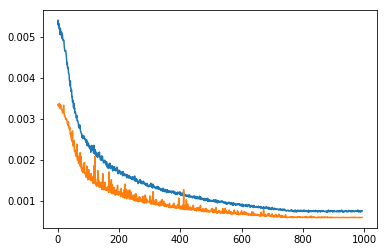

In [20]:
plt.plot(callback_list[1].history['train_loss'][5:])
plt.plot(callback_list[1].history['val_loss'][5:])

In [21]:
checkpoint = torch.load('../results/cnnnet/checkpoint-lr-scheduler-mse-loss.pth-best.tar')

## Loading the best model

In [22]:
from cpe775.utils.img_utils import show_landmarks_batch

In [23]:
best_model = Model(CNNNet((1, 256, 256), (68, 2)))
best_net = model.net
best_net.load_state_dict(checkpoint['state_dict'])

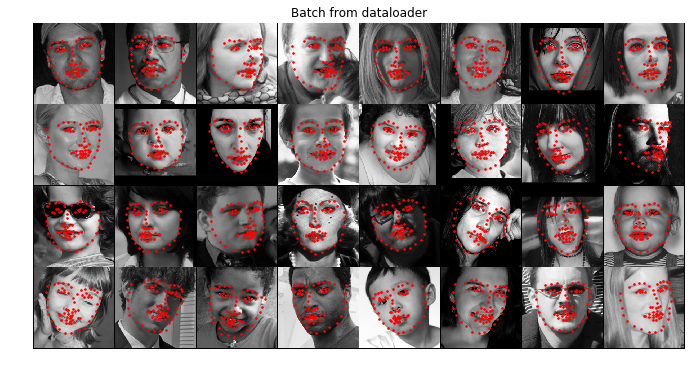

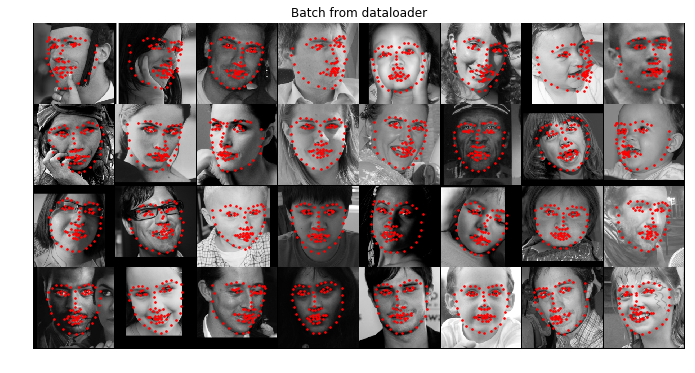

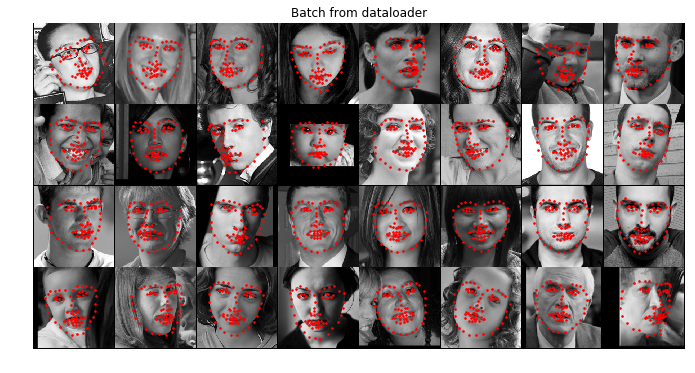

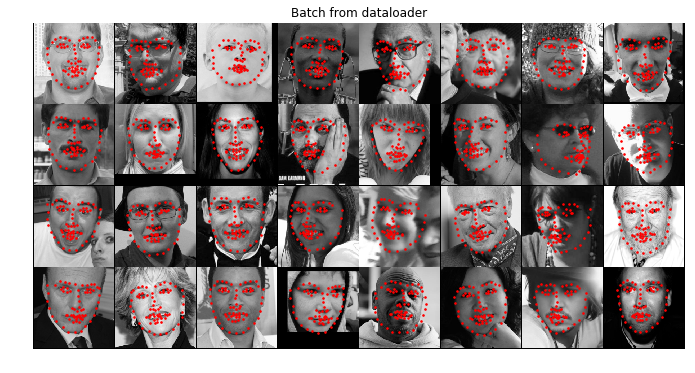

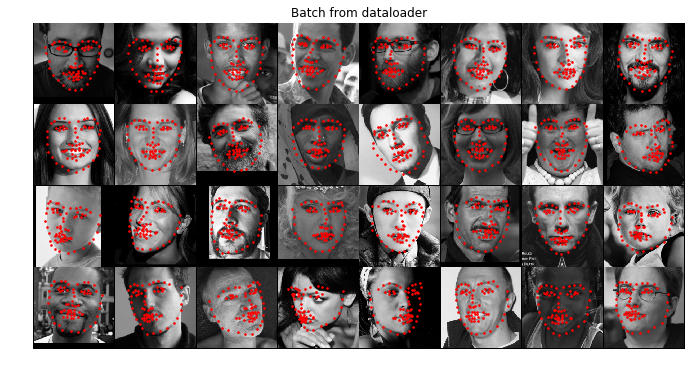

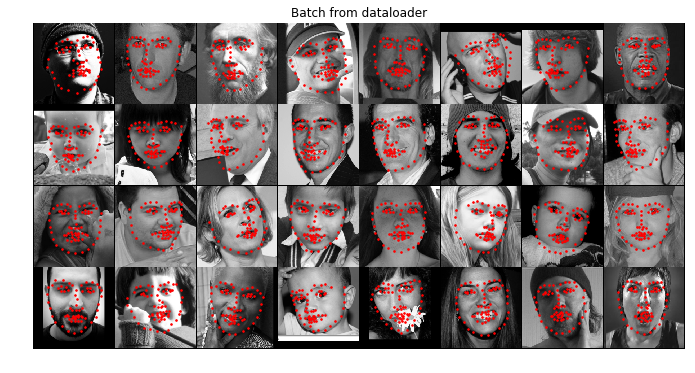

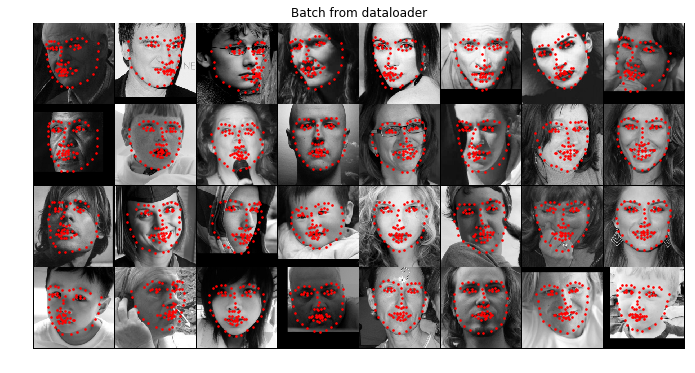

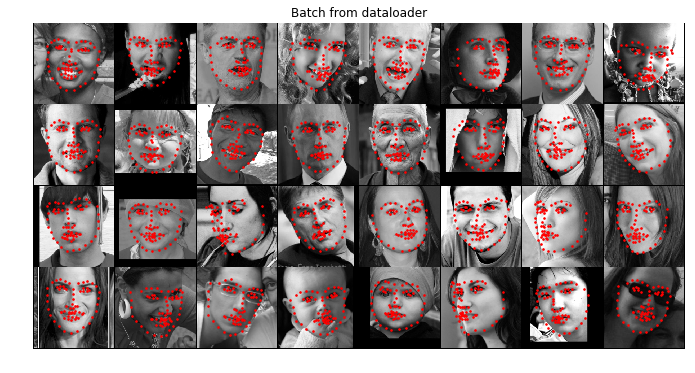

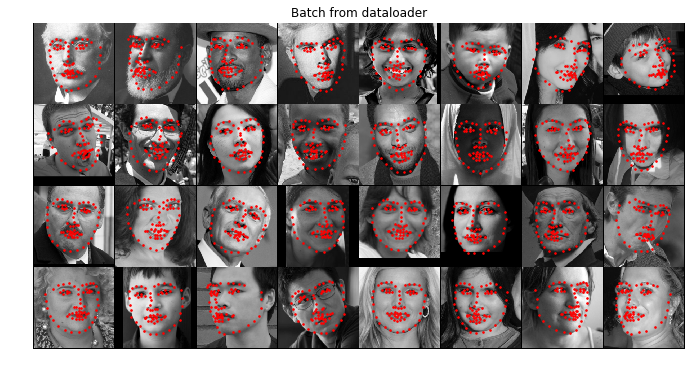

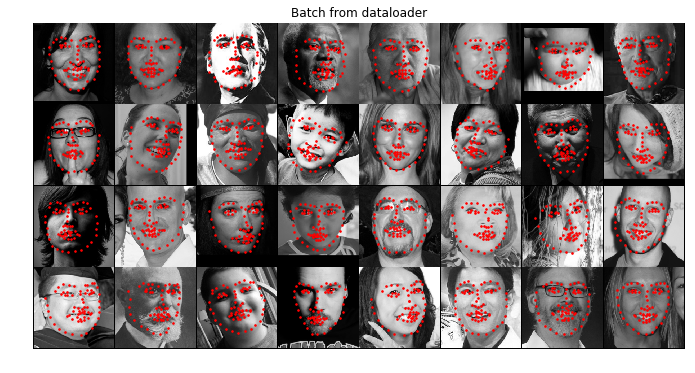

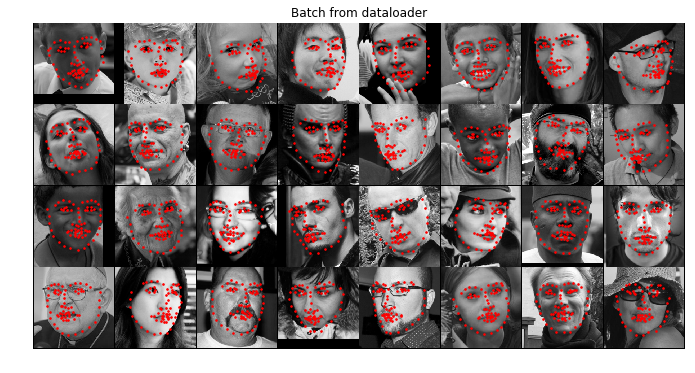

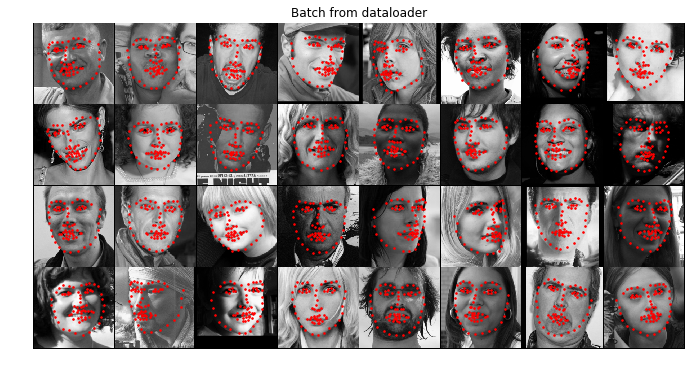

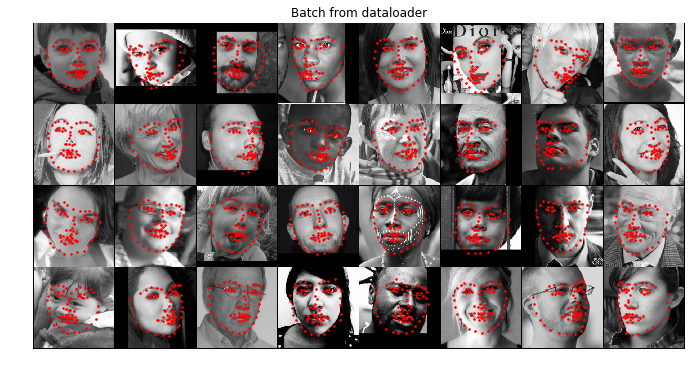

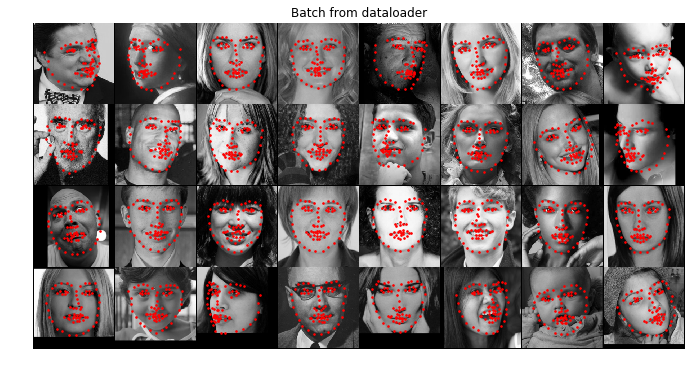

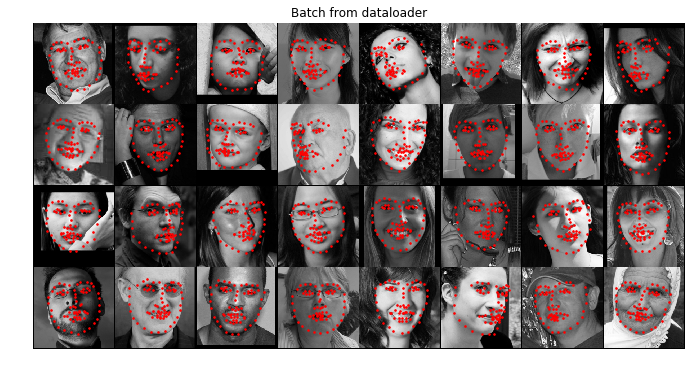

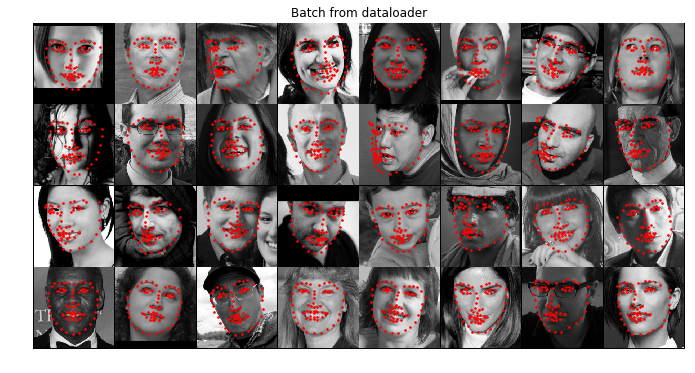

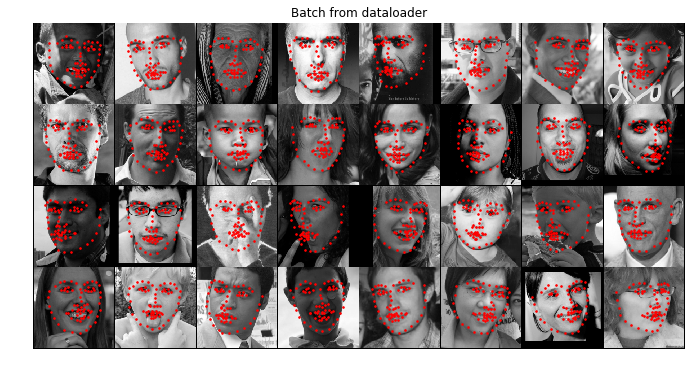

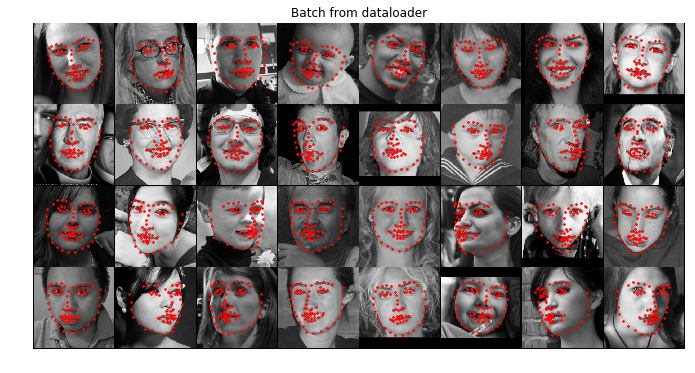

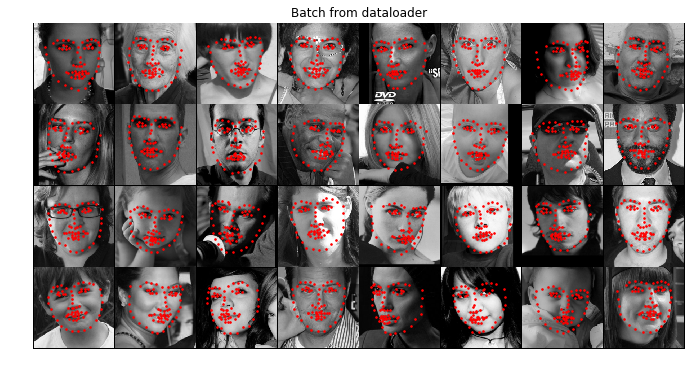

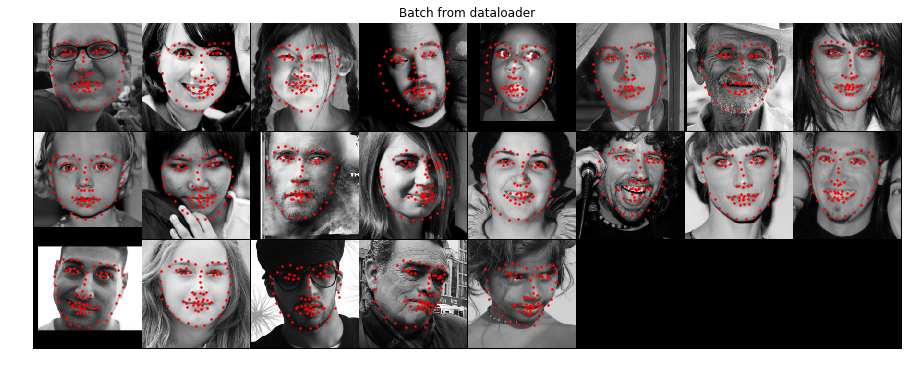

In [24]:
for i_batch, sample_batched in enumerate(valid_loader):
    
    predicted_landmarks = best_net(torch.autograd.Variable(sample_batched['image'], volatile=False)).cpu().data
    plt.figure(figsize=(20,6))
    show_landmarks_batch({'image': sample_batched['image'], 'landmarks': predicted_landmarks})
    plt.axis('off')
    plt.ioff()
    plt.show()

### Common test

In [25]:
transforms = Compose([
                   CropFace(),
                   CenterCrop((224,224)),
                   ToGray(),
                   ToTensor()
                 ])

In [26]:
# load the dataset
dataset = FaceLandmarksDataset(csv_file='../data/common_test.csv',
                               root_dir='../data/',
                               transform=transforms)

common_loader = torch.utils.data.DataLoader(dataset, 
                batch_size=batch_size, num_workers=4)

In [27]:
loss = 0
for i_batch, sample_batched in enumerate(common_loader):
    
    predicted_landmarks = best_net(torch.autograd.Variable(sample_batched['image'], volatile=False)).cpu().data
    
    loss += predicted_landmarks.shape[0]*criterion(predicted_landmarks, sample_batched['landmarks'])
    
    plt.figure(figsize=(20,6))
    show_landmarks_batch({'image': sample_batched['image'], 'landmarks': predicted_landmarks})
    plt.axis('off')
    plt.ioff()
    plt.show()

AttributeError: 'torch.FloatTensor' object has no attribute 'requires_grad'

In [ ]:
loss/len(dataset)

### Challenging test

In [ ]:
# load the dataset
challenging_set = FaceLandmarksDataset(csv_file='../data/challenging_test.csv',
                               root_dir='../data/',
                               transform=transforms)

challeging_loader = torch.utils.data.DataLoader(challenging_set, 
                batch_size=batch_size, num_workers=4)

In [ ]:
loss = 0
for i_batch, sample_batched in enumerate(challeging_loader):
    
    predicted_landmarks = best_net(torch.autograd.Variable(sample_batched['image'], volatile=False)).cpu().data
    
    loss += predicted_landmarks.shape[0]*criterion(predicted_landmarks, sample_batched['landmarks'])
    
    plt.figure(figsize=(20,6))
    show_landmarks_batch({'image': sample_batched['image'], 'landmarks': predicted_landmarks})
    plt.axis('off')
    plt.ioff()
    plt.show()

In [ ]:
loss/len(challenging_set)